In [14]:
from lib.utils import * # Import custom utility functions
import gymnasium as gym
import pogema
from pogema import GridConfig
from stable_baselines3 import DQN
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Set Global parameters
GRID_LEN = 18
GRID_SIZE = 8
DENSITY = 0.3
OBS_RADIUS = 5
MAX_EPISODE_STEPS = 64
SAVE_PARAMS_PATH = 'saved/tuned_params.yml'
SAVE_METRICS_PATH = 'saved/evaluation_metrics.yml'
MODEL_NAME = 'DQN_D'
MAX_TRIALS = 1000  # For evaluation_metrics()

def custom_step(self, action: list):
        assert len(action) == self.grid_config.num_agents
        rewards = []
        terminated = []

        self.move_agents(action)
        self.update_was_on_goal()

        for agent_idx in range(self.grid_config.num_agents):

            c_x, c_y = self.grid.positions_xy[agent_idx]
            f_x, f_y = self.grid.finishes_xy[agent_idx]

            reward = -( (abs(c_x - f_x) + abs(c_y - f_y)) / (2 * GRID_LEN) )
            #print(f"[CURR] {c_x}, {c_y} [FINISH] {f_x}, {f_y} [DIST] {d} [REWARD] {reward}")

            on_goal = self.grid.on_goal(agent_idx)
            if on_goal and self.grid.is_active[agent_idx]:
                print("FINISH", reward)
                rewards.append(100)
            else:
                rewards.append(reward)
            terminated.append(on_goal)

        for agent_idx in range(self.grid_config.num_agents):
            if self.grid.on_goal(agent_idx):
                self.grid.hide_agent(agent_idx)
                self.grid.is_active[agent_idx] = False

        infos = self._get_infos()

        observations = self._obs()
        truncated = [False] * self.grid_config.num_agents
        return observations, rewards, terminated, truncated, infos

pogema.envs.Pogema.step = custom_step

grid_config = GridConfig(
    size=GRID_SIZE,                                 # size of the grid map 8 = (8x8)
    density=DENSITY,                                # obstacle density
    num_agents=1,                                   # number of agents
    obs_radius=OBS_RADIUS,                          # defines field of view
    max_episode_steps=MAX_EPISODE_STEPS,            # time horizon
    seed=None                                       # set to None for random obstacles, agents and targets positions at each reset
)

env = gym.make("Pogema-v0",grid_config=grid_config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### DQN

Sources: 

* https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
* https://github.com/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/dqn_sb3.ipynb
* https://github.com/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb
* https://stable-baselines3.readthedocs.io/en/master/guide/tensorboard.html
    * https://stable-baselines3.readthedocs.io/en/master/common/logger.html#logger
    * https://www.tensorflow.org/tensorboard/get_started
    * https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml - Tuned Hyperparams for several gym envs (Hard Problem)

In [15]:
# load tuned hyperparameters into DQN model for agent training
model_params = get_model_log(MODEL_NAME, SAVE_PARAMS_PATH)
# add additional params for logging of agent training
extra_params = {
    "env":env,
    "tensorboard_log":"./tensorboard"
}
model_params.update(extra_params)
model = load_model_params(DQN, model_params)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:231: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.92GB > 0.02GB
  warnings.warn(


In [16]:
# Evaluate untrained agent using env
val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_dqn_model = DQN(
    "MlpPolicy",
    val_env,
    verbose=1
)

mean_reward, std_reward = evaluate_policy(
    val_dqn_model,
    val_dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=MAX_EPISODE_STEPS,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
mean_reward: -2.08 +/- 26.77


In [17]:
# Train agent and save it
model.learn(total_timesteps=int(3.0e5), tb_log_name=f"dqn_baseline_{MODEL_NAME}")
model.save(f"saved/dqn_baseline_{MODEL_NAME}")

Logging to ./tensorboard/dqn_baseline_DQN_D_3
FINISH -0.0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 57.5     |
|    ep_rew_mean      | 17       |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3494     |
|    time_elapsed     | 0        |
|    total_timesteps  | 230      |
----------------------------------
FINISH -0.0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.6     |
|    ep_rew_mean      | 16.3     |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4624     |
|    time_elapsed     | 0        |
|    total_timesteps  | 437      |
----------------------------------
FINISH -0.0
FINISH -0.0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 52.6     |
|    ep_rew_mean      | 25.6   

### Load trained agent and evaluate it

In [18]:
model = DQN.load(f"saved/dqn_baseline_{MODEL_NAME}")

env.reset()
mean_reward, std_reward = evaluate_policy(model, env, deterministic=True, n_eval_episodes=20)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:231: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.92GB > 2.32GB
  warnings.warn(
/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
mean_reward:19.86 +/- 46.33


In [19]:
from IPython.display import SVG, display

metrics = evaluate_metrics(model, env, MODEL_NAME, num_episodes=MAX_EPISODE_STEPS, num_trials=MAX_TRIALS, verbose=False, save_animation=True)
save_metrics(metrics, MODEL_NAME, SAVE_METRICS_PATH)
print(f"Agent Success Rate: {metrics['success_rate'] * 100:.2f}%")
print(f"Steps to termination : {metrics['step_array']}")
print(f"Average steps to termination : {metrics['ave_steps']}")
print(f"Reward for each successful trial: {metrics['reward_array']}")
print(f"Reward for each trial: {metrics['all_reward_array']}")

FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINISH -0.0
FINI

### Load Animation

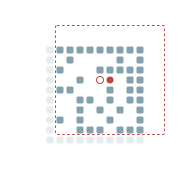

In [20]:
display(SVG(f'renders/render_{MODEL_NAME}.svg'))

### Tensorboard

In [21]:
%tensorboard --logdir tensorboard/dqn_baseline_DQN_D_1

Launching TensorBoard...